In [2]:
import numpy
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from importlib import reload
import InputList
import BinaryReader
import Preprocessor
import models
import Callbacks
import TFRecordsHandler
import os

2022-03-18 11:29:39.258478: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-03-18 11:29:39.258496: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-03-18 11:29:39.333390: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1630] Profiler found 1 GPUs
2022-03-18 11:29:39.334232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-03-18 11:29:39.358939: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-03-18 11:29:39.359399: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1764] CUPTI activity buffer flushed
2022-03-18 11:29:39.360578: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-03-18 11:29:39.360625: I tensorflow/core/profiler/lib/profiler_session.cc:125] Prof

In [3]:
reload(TFRecordsHandler)

<module 'TFRecordsHandler' from '/home/julius/dataspellprojects/oct-classifier/TFRecordsHandler.py'>

In [4]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6


2022-03-18 11:29:39.508466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 11:29:39.579124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 11:29:39.579308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 11:29:39.579605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
data_location = "/mnt/NewHDD/tfrecords_norm"
all_input_files = []
for path, subdirs, files in os.walk(data_location):
    for file in files:
        all_input_files.append(os.path.join(path, file))

In [6]:
reload(TFRecordsHandler)
def tfrecords_reader(list_of_files, deterministic=False):
    dataset = tf.data.Dataset.from_tensor_slices(list_of_files)
    if not deterministic:
        dataset = dataset.shuffle(len(list_of_files))
    dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x),
                                 num_parallel_calls=tf.data.AUTOTUNE,
                                 deterministic=deterministic) \
                      .prefetch(tf.data.AUTOTUNE)
    # pass every single feature through our mapping function
    dataset = dataset.map(
      TFRecordsHandler.parse_tfr_element
    )
    return dataset

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
reader = BinaryReader.BinaryReader()  # TODO: Normalizer

Num GPUs Available:  1


In [6]:
training_files, validation_files = reader.split_file_list_for_validation(all_input_files)

In [8]:
validation_files = all_input_files[0:400] + all_input_files[-400:]

In [30]:
import logging
logging.basicConfig(filename='model_training.log', encoding='utf-8', level=logging.DEBUG)

In [9]:
training_dataset = tfrecords_reader(all_input_files[400:-400])
validation_dataset = tfrecords_reader(validation_files, deterministic=True)

2022-03-18 11:30:00.048710: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-18 11:30:00.049362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 11:30:00.049504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 11:30:00.049586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
preproc = Preprocessor.Preprocessor(training_dataset)
normalization_layer = preproc.normalize_layer()

In [9]:
diabetic_counter = 0
healthy_counter = 0
for element in training_dataset:
    if element[1].numpy() == 1:
        diabetic_counter += 1
    if element[1].numpy() == 0:
        healthy_counter += 1

['/mnt/NewHDD/tfrecords_norm/0_18044_H5/b6_c0.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b8_c6.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b8_c4.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b2_c17.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b2_c12.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b2_c18.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b11_c19.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b12_c8.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b5_c2.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b11_c11.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b11_c7.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b4_c16.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b1_c2.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b1_c8.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b14_c3.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b2_c0.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_18044_H5/b2_c5.tfrecords',
 '/

In [10]:
a = 18 # TODO:
b = 15
class_weights = {0: (1/b) * (a+b)/2, 1:(1/a) * (a+b)/2}
class_weights

{0: 1.1, 1: 0.9166666666666666}

In [11]:
# TODO: steps per epoch
BATCH_SIZE = 1
NUM_SAMPLES_TRAIN = len(all_input_files[400:-400])
NUM_SAMPLES_VAL = len(validation_files)
CHECKPOINTS = 30
NUM_WALKTHROUGH = 20

In [12]:
reload(models)
model = models.classiRaw3D((1536, 102, 102, 1))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1536, 102, 102,   0         
                             1)]                                 
                                                                 
 reshape (Reshape)           (None, 156672, 102, 1)    0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 156672, 102, 1)   0         
 ropout2D)                                                       
                                                                 
 reshape_1 (Reshape)         (None, 1536, 102, 102, 1  0         
                             )                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 1536, 102, 102, 1  0        
 se)                         )                               

In [13]:
NUM_WALKTHROUGH = 30

In [14]:
print(model.layers[1].dtype_policy)

<Policy "mixed_float16">


In [15]:
train_steps=int(NUM_SAMPLES_TRAIN * NUM_WALKTHROUGH / (BATCH_SIZE * CHECKPOINTS))
val_steps=int(NUM_SAMPLES_VAL * NUM_WALKTHROUGH / (BATCH_SIZE * CHECKPOINTS))
print(train_steps, val_steps)

13600 800


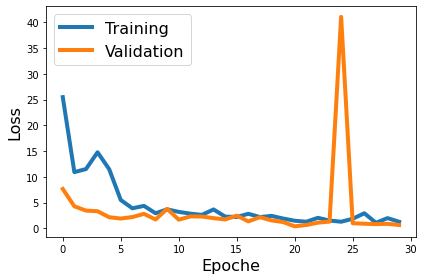

13600/13600 [==============================] - 6413s 472ms/step - loss: 1.2891 - accuracy: 0.7228 - val_loss: 0.6611 - val_accuracy: 0.9887


2022-03-20 17:09:13.461818: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: savedModels/third/assets


In [16]:
history = model.fit(
    training_dataset.batch(BATCH_SIZE).repeat(),
    epochs=CHECKPOINTS,
    validation_data=validation_dataset.batch(BATCH_SIZE).repeat(),
    callbacks=Callbacks.my_callbacks,
    class_weight=class_weights,
    use_multiprocessing=True,
    steps_per_epoch= train_steps,
    validation_steps=val_steps
)
model.save('savedModels/third')

In [ ]:
#normalization_weights = normalization_layer.get_weights()
#print("Before:" + str(normalization_weights))
# normalization_weights_path = "results/normalization.npy"
# #np.save(normalization_weights_path, normalization_weights)
# normalization_layer.set_weights(np.load(normalization_weights_path))
# print("After" + str(normalization_layer.get_weights()))

In [38]:
model.save('savedModels/new_mode_old_result1803')

2022-03-18 11:23:41.022144: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: savedModels/new_mode_old_result1803/assets


In [17]:
trained_model = keras.models.load_model('savedModels/third')

(3, 3, 3, 32)


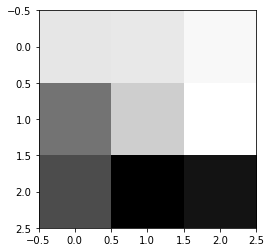

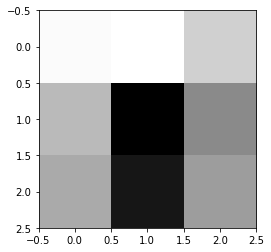

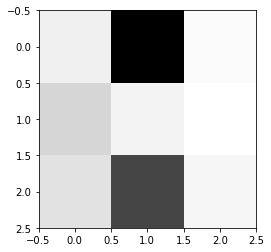

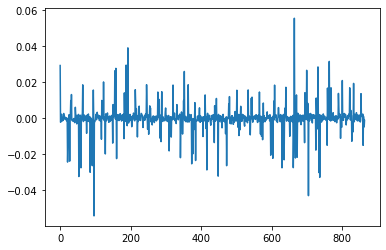

In [29]:
import matplotlib.pyplot as plt
weights_to_plot = model.layers[5].get_weights()[0][:,:,:,0,:]
print(weights_to_plot.shape)
plt.imshow(weights_to_plot[:, :, 0, 2], cmap="Greys")
fig = plt.figure()
plt.imshow(weights_to_plot[:, :, 1, 2], cmap="Greys")
fig = plt.figure()
plt.imshow(weights_to_plot[:, :, 2, 2], cmap="Greys")
fig = plt.figure()
plt.plot(weights_to_plot.flatten())

In [247]:
test_dataset = tfrecords_reader(['/mnt/NewHDD/tfrecords/1_30720/b1_c0.tfrecords'])

In [249]:
for elem in test_dataset:
    print(elem[1])

tf.Tensor([0], shape=(1,), dtype=int64)


In [119]:
a = 9600
all_input_files[a:a+400]

['/mnt/NewHDD/tfrecords_norm/0_15453_H1/b6_c0.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b8_c6.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b8_c4.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b2_c17.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b2_c12.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b2_c18.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b11_c19.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b12_c8.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b5_c2.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b11_c11.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b11_c7.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b4_c16.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b1_c2.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b1_c8.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b14_c3.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b2_c0.tfrecords',
 '/mnt/NewHDD/tfrecords_norm/0_15453_H1/b2_c5.tfrecords',
 '/

In [120]:
check_set = tfrecords_reader(all_input_files[a:a+400], True)

In [121]:
output_test6 = model.predict(
    check_set.batch(1),
    verbose = 1,
    use_multiprocessing=True
)

400/400 [==============================] - 162s 399ms/step


In [118]:
output_test6

array([[-212.1 ],
       [-228.8 ],
       [-214.2 ],
       [-219.6 ],
       [-222.5 ],
       [-226.9 ],
       [-203.4 ],
       [-229.8 ],
       [-236.4 ],
       [-208.5 ],
       [-223.6 ],
       [-230.1 ],
       [-215.8 ],
       [-202.8 ],
       [-204.6 ],
       [-218.9 ],
       [-211.8 ],
       [-218.1 ],
       [-202.  ],
       [-227.5 ],
       [-217.  ],
       [-218.8 ],
       [-198.1 ],
       [-200.4 ],
       [-226.9 ],
       [-229.8 ],
       [-220.4 ],
       [-215.6 ],
       [-232.6 ],
       [-237.9 ],
       [-203.6 ],
       [-205.4 ],
       [-233.  ],
       [-231.2 ],
       [-220.2 ],
       [-222.5 ],
       [-226.4 ],
       [-226.4 ],
       [-203.2 ],
       [-219.9 ],
       [-226.8 ],
       [-207.8 ],
       [-206.9 ],
       [-222.4 ],
       [-227.2 ],
       [-227.6 ],
       [-202.4 ],
       [-217.2 ],
       [-215.1 ],
       [-195.9 ],
       [-200.4 ],
       [-199.6 ],
       [-215.5 ],
       [-191.5 ],
       [-229.2 ],
       [-2

In [115]:
import utils
reload(utils)
results_map = utils.reorder_by_name(all_input_files[1200:1600], output_test6)

In [116]:
print(np.min(results_map))
print(np.max(results_map))
print(results_map)

-237.875
97.4375
[[  84.3125  -212.5     -227.625   -209.5     -232.75    -221.125
    90.0625    79.125     67.125   -225.375   -221.        71.25
    70.875     84.      -232.625     66.75    -203.125   -210.25
    61.4375  -228.125  ]
 [  81.1875  -215.75    -215.75    -212.5     -221.375     83.4375
  -208.        82.125   -202.75      68.9375  -210.875     62.21875
  -229.25    -224.625   -205.75    -207.75      82.5625  -203.25
    69.75      85.8125 ]
 [-218.875   -224.25      71.        75.5625  -217.      -211.75
    88.3125    70.4375  -217.875     87.25      75.1875  -216.5
  -222.5     -220.375     65.5       91.25    -226.375   -219.625
  -226.875     76.625  ]
 [-232.75      69.8125    70.6875  -213.625   -233.        51.78125
  -203.125     69.3125    72.5     -231.25    -229.375     64.1875
  -219.25      60.1875    84.625   -202.      -203.875     71.0625
  -197.625   -198.375  ]
 [-215.625   -206.375     79.625   -216.875     88.125   -221.75
  -202.75      73.0625   

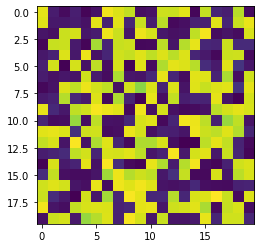

In [117]:
plt.imshow(results_map)
import Visualization
reload(Visualization)
vsz = Visualization.ImageVisualizer(results_map.reshape((400,1)), instance_size=(102, 102, 20, 20), background_image_path="/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D113/links/retina_1536x2048x2045x2_30720.png")
vsz.plot_results_map(name="wrong_x2_again")

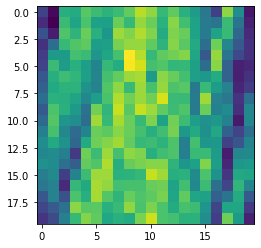

In [70]:
plt.imshow(results_map)

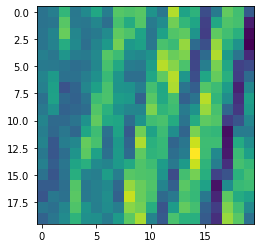

In [99]:
plt.imshow(results_map)
import Visualization
reload(Visualization)
vsz = Visualization.ImageVisualizer(results_map.reshape((400,1)), instance_size=(102, 102, 20, 20), background_image_path="/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D113/links/retina_1536x2048x2045x2_30720.png")
vsz.plot_results_map(name="healthy_wrong_x2")

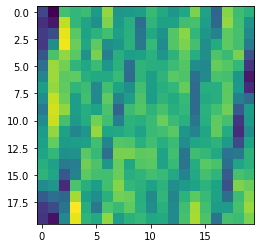

In [59]:
plt.imshow(results_map)

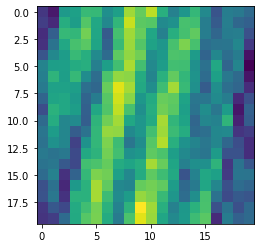

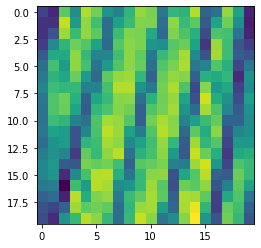

In [46]:
plt.imshow(results_map)
plt.figure()
plt.imshow(results_map_old)

In [39]:
import Visualization
reload(Visualization)
vsz = Visualization.ImageVisualizer(results_map.reshape((400,1)), instance_size=(102, 102, 20, 20), background_image_path="/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D113/links/retina_1536x2048x2045x2_30720.png")
vsz.plot_results_map(name="diabetic_validation_gauss_noise")

In [12]:
reload(BinaryReader)
reader = BinaryReader.BinaryReader()
test_dataset_diabetic_1 = reader.create_test_dataset([("/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D101/rechts/raw_1536x2048x2045x2_21193.bin", 1)])
test_dataset_diabetic_2 = reader.create_test_dataset([("/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D85/rechts/raw_1536x2048x2045x2_19200.bin", 1)])
# output_test_healthy = model.predict(
#     test_dataset.batch(1),
#     verbose = 1,
#     use_multiprocessing=True
# )

In [78]:
for elem in test_dataset_diabetic_1.take(1):
    mean_scan = np.mean(elem[0].numpy().reshape((1536, 102 * 102)), axis=1)
    var_scan = np.var(elem[0].numpy().reshape((1536, 102 * 102)), axis=1)

InvalidArgumentError: Incompatible shapes: [1536,102,102,1] vs. [1536,1] [Op:Sub]

In [13]:
for elem in test_dataset_diabetic_1.take(1):
    mean_scan = np.mean(elem[0].numpy().reshape((1536, 102 * 102)), axis=1)
    var_scan = np.var(elem[0].numpy().reshape((1536, 102 * 102)), axis=1)
test_dataset_diabetic_1 = reader.create_test_dataset([("/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D101/rechts/raw_1536x2048x2045x2_21193.bin", 1)])
test_dataset_diabetic_3 = test_dataset_diabetic_1.map(lambda x, y: (tf.reshape((tf.cast(
    tf.reshape(x, (1536, 102*102)), "float64") - tf.convert_to_tensor(mean_scan.reshape((1536, 1)))) / \
           tf.convert_to_tensor(var_scan.reshape((1536, 1))**0.5), (1536, 102, 102, 1)), y))

for elem in test_dataset_diabetic_2.take(1):
    mean_scan = np.mean(elem[0].numpy().reshape((1536, 102 * 102)), axis=1)
    var_scan = np.var(elem[0].numpy().reshape((1536, 102 * 102)), axis=1)
test_dataset_diabetic_2 = reader.create_test_dataset([("/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D85/rechts/raw_1536x2048x2045x2_19200.bin", 1)])
test_dataset_diabetic_4 = test_dataset_diabetic_2.map(lambda x, y: (tf.reshape((tf.cast(
    tf.reshape(x, (1536, 102*102)), "float64") - tf.convert_to_tensor(mean_scan.reshape((1536, 1)))) / \
           tf.convert_to_tensor(var_scan.reshape((1536, 1))**0.5), (1536, 102, 102, 1)), y))

In [122]:
test_wenig_diabetic = model.predict(
    test_dataset_diabetic_3.batch(1),
    verbose = 1,
    use_multiprocessing=True
)
test_viel_diabetic = model.predict(
    test_dataset_diabetic_4.batch(1),
    verbose = 1,
    use_multiprocessing=True
)

400/400 [==============================] - 302s 745ms/step


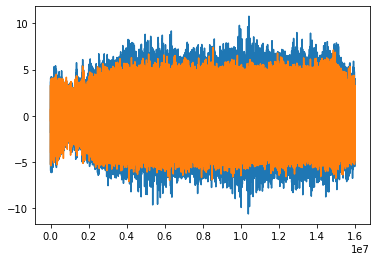

In [165]:
for belem in test_dataset_diabetic_4.take(1):
    plt.plot(celem[0][:,:,:,0].numpy().flatten())
    plt.plot(elem[0][:,:,:,0].numpy().flatten())
    plt.plot(belem[0][:,:,:,0].numpy().flatten())


In [14]:
i = 0
for celem in test_dataset_diabetic_4:
    i += 1
    if i == 1:
        background_elem1 = celem
    if i == 42:
        background_elem2 = celem
    if i == 67:
        retina_elem1 = celem
    if i == 96:
        retina_elem2 = celem
        break
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


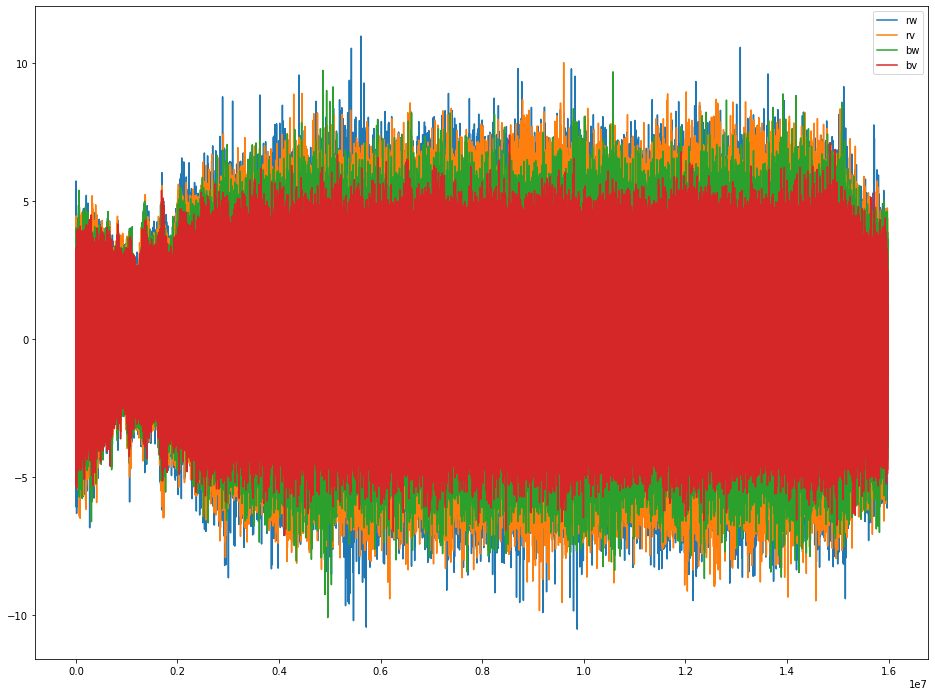

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
plt.plot(retina_elem1[0][:,:,:,0].numpy().flatten())
plt.plot(retina_elem2[0][:,:,:,0].numpy().flatten())
plt.plot(background_elem2[0][:,:,:,0].numpy().flatten())
plt.plot(background_elem1[0][:,:,:,0].numpy().flatten())
plt.legend(["rw", "rv", "bv", "bw"])

In [157]:
np.std(elem[0][:,:,:,0].numpy().flatten())

0.9999999999999998

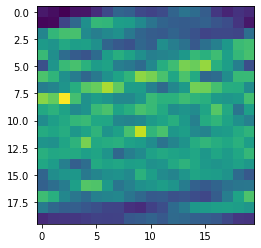

In [132]:
plt.imshow(test_wenig_diabetic.reshape((20, 20)))

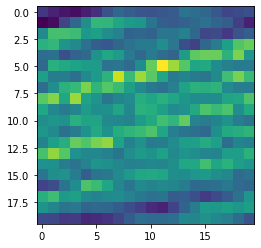

In [133]:
plt.imshow(test_viel_diabetic.reshape((20, 20)))

Wenig diabetisch:
retina_1536x2048x2045x2_21193.png
raw_1536x2048x2045x2_21193.bin
/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D101/rechts

Viel diabetisch:
retina_1536x2048x2045x2_19200.png
raw_1536x2048x2045x2_19200.bin
/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D85/rechts

In [143]:
import Visualization
reload(Visualization)
vsz = Visualization.ImageVisualizer(test_wenig_diabetic.reshape((400,1)), instance_size=(102, 102, 20, 20), background_image_path="/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D101/rechts/retina_1536x2048x2045x2_21193.png")
vsz.plot_results_map(name="wenig_diabetic_test")

In [78]:
reshaped_test = np.zeros((20,20))
for file, output in zip(all_input_files[400:800], output_test):
    b_and_c_dim = file.split(".")[0].split("/")[-1].split("_")
    b_dim = b_and_c_dim[0][1:]
    c_dim = b_and_c_dim[1][1:]
    reshaped_test[int(b_dim), int(c_dim)] = output

In [236]:
output_test5[:10]

array([[-13.660425 ],
       [-12.056449 ],
       [-12.290262 ],
       [  2.0876215],
       [-10.84602  ],
       [  2.1266456],
       [  2.0506701],
       [  2.05468  ],
       [  2.014648 ],
       [-11.384293 ]], dtype=float32)

In [241]:
output_test5[:,0].shape

(2880,)

In [254]:
import Postprocessor
labels = []
for elem in validation_dataset:
    labels.append(elem[1])
# for file, output in zip(validation_files, output_test5):
#     labels.append(int(file.split("/")[4][0]))
pp = Postprocessor.Postprocessing(output_test5[:,0], labels)
pp.binary_confusion_matrix()

KeyboardInterrupt: 

In [260]:
labels = [label.numpy() for label in labels]
labels

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

[[772  24]
 [  0 904]]


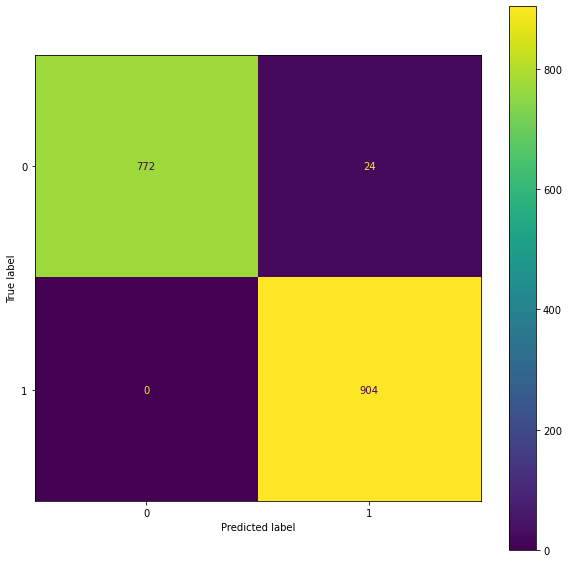

In [266]:
reload(Postprocessor)
pp = Postprocessor.Postprocessing(output_test5[:1700,0], labels[:1700])
pp.binary_confusion_matrix()

In [75]:
b_and_c_dim = file.split(".")[0].split("/")[-1].split("_")
b_dim = b_and_c_dim[0][1:]
c_dim = b_and_c_dim[1][1:]

In [77]:
b_dim, c_dim

('6', '0')

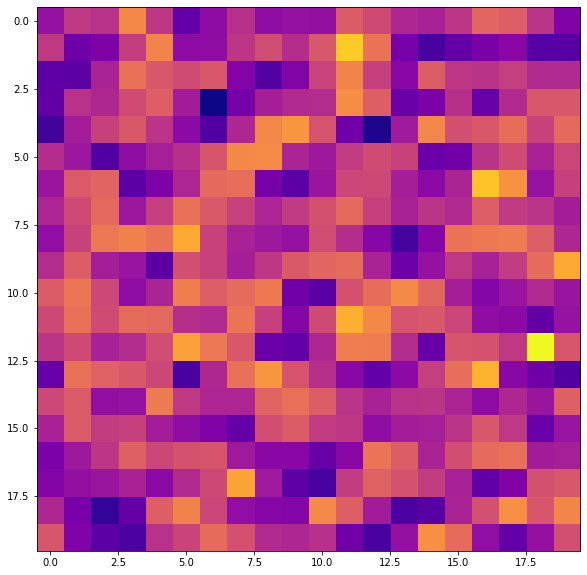

In [206]:
fig = plt.figure(figsize=(20, 10))
plt.imshow(output_test.reshape((20, 20)), cmap="plasma")

In [165]:
import Visualization
reload(Visualization)
vsz = Visualization.ImageVisualizer(output_ensure.reshape((400,1)), instance_size=(102, 102, 20, 20), background_image_path="/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D113/links/retina_1536x2048x2045x2_30720.png")
vsz.plot_results_map(name="healthy_test2")